# Computing the optimal statistic with `enterprise`

* In this notebook you will learn how to compute the optimal statistic. 
* The optimal statistic is a frequentist detection statistic for the stochastic background. 
* It assesses the significance of the cross-correlations and compares them to the Hellings-Downs curve.

* For more information, see [Anholm et al. 2009](https://arxiv.org/abs/0809.0701), [Demorest et al. 2013](https://arxiv.org/abs/1201.6641), [Chamberlin et al. 2015](https://arxiv.org/abs/1410.8256), [Vigeland et al. 2018](https://arxiv.org/abs/1805.12188).

* This notebook shows you how to compute the optimal statistic for the 12.5yr data set.

In [1]:
import numpy as np
import json

import matplotlib.pyplot as plt
%matplotlib inline

from enterprise_extensions import models
from enterprise_extensions.frequentist import optimal_statistic as opt_stat

from settings import matplotsettings, load_pulsars
matplotsettings()

import sys
IN_COLAB = 'google.colab' in sys.modules

## Load pulsar data

In [2]:
if IN_COLAB:
    datadir = '/content/12p5yr_stochastic_analysis/tutorials/data'
else:
    datadir = './data'

In [3]:
# load the pulsars (picking PINT or TEMPO2 timing packages and the ephemeris)
# set save = True to save a pickle and reduce load times significantly (at the cost of 1.8GB of space.)
psrs = load_pulsars(datadir, PINT=False, ephemeris='DE438', save=False)

In [4]:
## Get parameter noise dictionary
noise_ng12 = datadir + '/channelized_12p5yr_v3_full_noisedict.json'

params = {}
with open(noise_ng12, 'r') as fp:
    params.update(json.load(fp))

### Use `enterprise_extensions` to make a model with a common red process

In [5]:
# (Note: It will take a few minutes to run this cell and may require at least ~4GB RAM)
# This will NOT work if we use tm_marg=True, so we don't use it here.
pta = models.model_2a(psrs, noisedict=params, gamma_common=4.33, n_gwbfreqs=5, tnequad=True, tm_svd=True)

### Initialize the optimal statistic object

In [6]:
ostat = opt_stat.OptimalStatistic(psrs, pta=pta, orf='hd')
ostat_dip = opt_stat.OptimalStatistic(psrs, pta=pta, orf='dipole')
ostat_mono = opt_stat.OptimalStatistic(psrs, pta=pta, orf='monopole')

## Load the maximum-likelihood values for the pulsars' red noise parameters and the common red process
* These values come from the results of a Bayesian search (model 2A)
* Once you have done your own Bayesian search, you can make your own parameter dictionary of maximum-likelihood values

In [7]:
with open(datadir + '/12p5yr_maxlike.json', 'r') as f:
    ml_params = json.load(f)

## Optimal statistics with maximum likelihood noise parameters
* The optimal statistic returns five quantities:
  - xi: an array of the angular separations between the pulsar pairs (in radians)
  - rho: an array of the cross-correlations between the pulsar pairs
  - sig: an array of the uncertainty in the cross-correlations
  - OS: the value of the optimal statistic
  - OS_sig: the uncertainty in the optimal statistic
 

In [8]:
xi, rho, sig, OS, OS_sig = ostat.compute_os(params=ml_params)
print(OS, OS_sig, OS/OS_sig)

_, _, _, OS_dip, OS_sig_dip = ostat_dip.compute_os(params=ml_params)
print(OS_dip, OS_sig_dip, OS_dip/OS_sig_dip)

_, _, _, OS_mono, OS_sig_mono = ostat_mono.compute_os(params=ml_params)
print(OS_mono, OS_sig_mono, OS_mono/OS_sig_mono)

4.1444420359885124e-30 1.5391035685415692e-30 2.6927635805014227
9.19091235170906e-31 4.027255069761986e-31 2.2821778587399604
8.766408092234487e-31 2.7496540387976453e-31 3.1881858475795077


### Plot the cross-correlations and compare to the Hellings-Downs curve

In [9]:
def get_HD_curve(zeta):
    
    coszeta = np.cos(zeta*np.pi/180.)
    xip = (1.-coszeta) / 2.
    HD = 3.*( 1./3. + xip * ( np.log(xip) -1./6.) )
    
    return HD/2

## Before plotting, we need to bin the cross-correlations

def weightedavg(rho, sig):
    weights, avg = 0., 0.
    for r,s in zip(rho,sig):
        weights += 1./(s*s)
        avg += r/(s*s)
        
    return avg/weights, np.sqrt(1./weights)

def bin_crosscorr(zeta, xi, rho, sig):

    rho_avg, sig_avg = np.zeros(len(zeta)), np.zeros(len(zeta))

    for i,z in enumerate(zeta[:-1]):
        myrhos, mysigs = [], []
        for x,r,s in zip(xi,rho,sig):
            if x >= z and x < (z+10.):
                myrhos.append(r)
                mysigs.append(s)
        rho_avg[i], sig_avg[i] = weightedavg(myrhos, mysigs)
        
    return rho_avg, sig_avg

# sort the cross-correlations by xi
idx = np.argsort(xi)

xi_sorted = xi[idx]
rho_sorted = rho[idx]
sig_sorted = sig[idx]

# bin the cross-correlations so that there are the same number of pairs per bin
npairs = 66

xi_mean = []
xi_err = []

rho_avg = []
sig_avg = []

i = 0
while i < len(xi_sorted):
    
    xi_mean.append(np.mean(xi_sorted[i:npairs+i]))
    xi_err.append(np.std(xi_sorted[i:npairs+i]))

    r, s = weightedavg(rho_sorted[i:npairs+i], sig_sorted[i:npairs+i])
    rho_avg.append(r)
    sig_avg.append(s)
    
    i += npairs
    
xi_mean = np.array(xi_mean)
xi_err = np.array(xi_err)

## Reproduce the bottom panel of Figure 5 in [https://arxiv.org/abs/2009.04496](https://arxiv.org/abs/2009.04496)

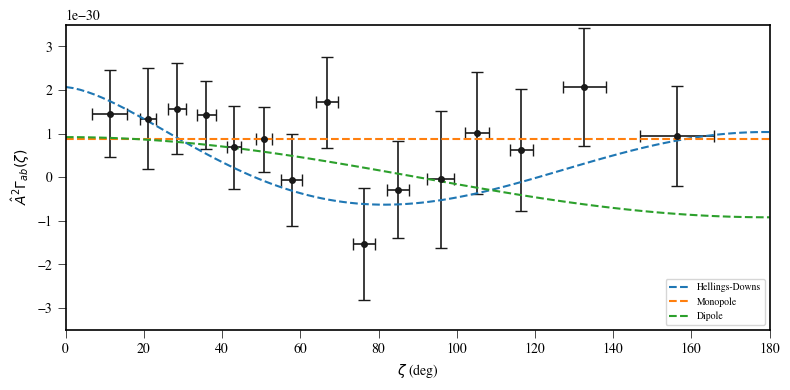

In [10]:
# reproduce the bottom panel of Figure 5 in https://arxiv.org/abs/2009.04496
plt.figure(figsize=(8, 4))
(_, caps, _) = plt.errorbar(xi_mean*180/np.pi, rho_avg, xerr=xi_err*180/np.pi, yerr=sig_avg, marker='o', ls='', 
                            color='0.1', capsize=4, elinewidth=1.2)

zeta = np.linspace(0.01,180,100)
HD = get_HD_curve(zeta+1)

plt.plot(zeta, OS*HD, ls='--', label='Hellings-Downs', color='C0', lw=1.5)
plt.plot(zeta, zeta*0.0+OS_mono, ls='--', label='Monopole', color='C1', lw=1.5)
plt.plot(zeta, OS_dip*np.cos(zeta*np.pi/180), ls='--', label='Dipole', color='C2', lw=1.5)

plt.xlim(0, 180);
plt.ylim(-3.5e-30, 3.5e-30);
plt.ylabel(r'$\hat{A}^2 \Gamma_{ab}(\zeta)$')
plt.xlabel(r'$\zeta$ (deg)');

plt.legend(loc=4);

plt.tight_layout();
plt.show();

## Noise marginalized optimal statistics
* To compute the noise-marginalized optimal statistic (Vigeland et al. 2018), you will need the chain from a Bayesian search for a common red process without spatial correlations (model 2A).
* NOTE: This file requires the "model_2a, 5 frequency power law, fixed spectral index (gamma=4.33)" chain from `download_full_chains.ipynb`

### Download chains used below:

In [11]:
import os
if IN_COLAB:
    dl_path = '/content/12p5yr_stochastic_analysis/chains/downloaded_chains/'
else:
    dl_path = './chains/downloaded_chains/'
if not os.path.exists(dl_path):
    os.makedirs(dl_path)

In [12]:
if IN_COLAB:
    # download params
    !curl https://data.nanograv.org/static/data/12p5yr_chains/12p5yr_DE438_model2a_cRN5freq_gammaFixed4.33_pars.txt -o /content/12p5yr_stochastic_analysis/chains/downloaded_chains/12p5yr_DE438_model2a_cRN5freq_gammaFixed4.33_pars.txt
    # download chain
    !curl https://data.nanograv.org/static/data/12p5yr_chains/12p5yr_DE438_model2a_cRN5freq_gammaFixed4.33_chain.gz -o /content/12p5yr_stochastic_analysis/chains/downloaded_chains/12p5yr_DE438_model2a_cRN5freq_gammaFixed4.33_chain.gz
else:
    # download params
    !curl https://data.nanograv.org/static/data/12p5yr_chains/12p5yr_DE438_model2a_cRN5freq_gammaFixed4.33_pars.txt -o ./chains/downloaded_chains/12p5yr_DE438_model2a_cRN5freq_gammaFixed4.33_pars.txt
    # download chain
    !curl https://data.nanograv.org/static/data/12p5yr_chains/12p5yr_DE438_model2a_cRN5freq_gammaFixed4.33_chain.gz -o ./chains/downloaded_chains/12p5yr_DE438_model2a_cRN5freq_gammaFixed4.33_chain.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2519  100  2519    0     0   2147      0  0:00:01  0:00:01 --:--:--  2147
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  177M  100  177M    0     0  4822k      0  0:00:37  0:00:37 --:--:-- 8637k


### Load the samples from a Bayesian run

In [13]:
# (Note: It will take a minute to run this cell)

chain = np.loadtxt(dl_path + '/12p5yr_DE438_model2a_cRN5freq_gammaFixed4.33_chain.gz')
params = np.loadtxt(dl_path + '/12p5yr_DE438_model2a_cRN5freq_gammaFixed4.33_pars.txt', dtype=str)

### Take the median values from the chains and dump them into a `json` file

In [14]:
param_dict = {}
params = list(params)
for p in params:
    param_dict.update({p: np.median(chain[:, params.index(p)])})

with open(datadir + '/12p5yr_median.json', 'w') as f:
    json.dump(param_dict, f)

In [15]:
# (Note: It may take a few minutes to run this cell)
N = 1000   # number of times to compute the optimal statistic - official analysis used 10k - you can increase this if you don't mind the extra runtime
burn = int(0.25*chain.shape[0])   # estimate of when the chain has burned in

noisemarg_OS, noisemarg_OS_err = np.zeros(N), np.zeros(N)
noisemarg_OS_dip, noisemarg_OS_dip_err = np.zeros(N), np.zeros(N)
noisemarg_OS_mono, noisemarg_OS_mono_err = np.zeros(N), np.zeros(N)

for i in range(N):
    if i%100==0:
        print("Status: ", i, "/", N, " -- ", i/N*100, " %")
    # choose a set of noise values from the chain
    # make sure that you pull values from after the chain has burned in
    idx = np.random.randint(burn, chain.shape[0])
    
    # construct a dictionary with these parameter values
    param_dict = {}
    for p in params:
        param_dict.update({p: chain[idx, params.index(p)]})
    
    # compute the optimal statistic at this set of noise values and save in an array
    _, _, _, noisemarg_OS[i], noisemarg_OS_err[i] = ostat.compute_os(params=param_dict)
    _, _, _, noisemarg_OS_dip[i], noisemarg_OS_dip_err[i] = ostat_dip.compute_os(params=param_dict)
    _, _, _, noisemarg_OS_mono[i], noisemarg_OS_mono_err[i] = ostat_mono.compute_os(params=param_dict)

Status:  0 / 1000  --  0.0  %
Status:  100 / 1000  --  10.0  %
Status:  200 / 1000  --  20.0  %
Status:  300 / 1000  --  30.0  %
Status:  400 / 1000  --  40.0  %
Status:  500 / 1000  --  50.0  %
Status:  600 / 1000  --  60.0  %
Status:  700 / 1000  --  70.0  %
Status:  800 / 1000  --  80.0  %
Status:  900 / 1000  --  90.0  %


## Reproduce Figure 4 (bottom panel) from [https://arxiv.org/abs/2009.04496](https://arxiv.org/abs/2009.04496)

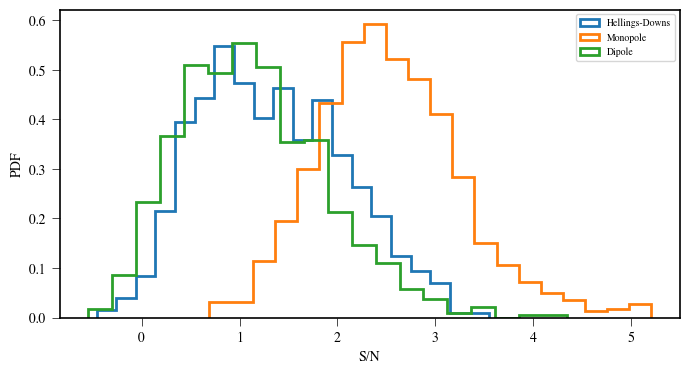

In [16]:
plt.figure(figsize=(8, 4))

plt.hist(noisemarg_OS/noisemarg_OS_err, histtype='step', lw=2, label='Hellings-Downs', color='C0',
         bins=20, density=True)
plt.hist(noisemarg_OS_mono/noisemarg_OS_mono_err, histtype='step', lw=2, label='Monopole', color='C1',
         bins=20, density=True)
plt.hist(noisemarg_OS_dip/noisemarg_OS_dip_err, histtype='step', lw=2, label='Dipole', color='C2',
         bins=20, density=True)

# plt.gca().axvline(x=np.mean(noisemarg_OS/noisemarg_OS_err), ls='--', color='C0')
# plt.gca().axvline(x=np.mean(noisemarg_OS_mono/noisemarg_OS_mono_err), ls='--', color='C1')
# plt.gca().axvline(x=np.mean(noisemarg_OS_dip/noisemarg_OS_dip_err), ls='--', color='C2')

# plt.gca().axvline(x=OS/OS_sig, ls=':', color='C0')
# plt.gca().axvline(x=OS_mono/OS_sig_mono, ls=':', color='C1')
# plt.gca().axvline(x=OS_dip/OS_sig_dip, ls=':', color='C2')

plt.legend(loc="upper right")
plt.xlabel("S/N")
plt.ylabel("PDF")

plt.show()

## Reproduce Figure 4 (top panel)

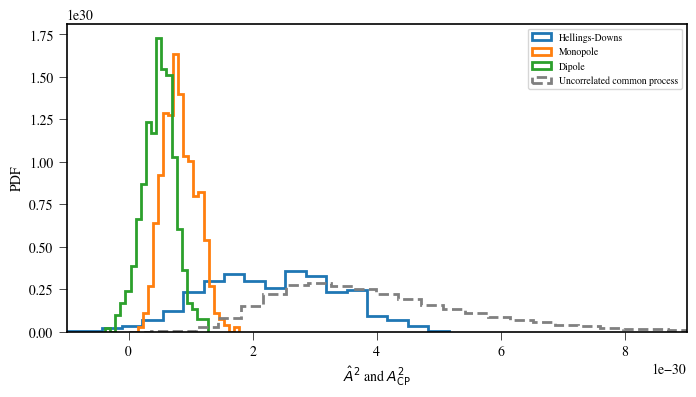

In [17]:
plt.figure(figsize=(8, 4))

plt.hist(noisemarg_OS, histtype='step', lw=2, label='Hellings-Downs', color='C0', bins=20, density=True)
plt.hist(noisemarg_OS_mono, histtype='step', lw=2, label='Monopole', color='C1', bins=20, density=True)
plt.hist(noisemarg_OS_dip, histtype='step', lw=2, label='Dipole', color='C2', bins=20, density=True)
plt.hist((10**(chain[:,params.index("gw_log10_A")]))**2, histtype='step', lw=2, label='Uncorrelated common process',
         color='grey', ls='--', bins=50, density=True)

# plt.gca().axvline(x=np.mean(noisemarg_OS), ls='--', color='C0')
# plt.gca().axvline(x=np.mean(noisemarg_OS_mono), ls='--', color='C1')
# plt.gca().axvline(x=np.mean(noisemarg_OS_dip), ls='--', color='C2')
# plt.gca().axvline(x=np.mean(10**(2*chain[:,params.index("gw_log10_A")])), ls='--', color='grey')

# plt.gca().axvline(x=OS, ls=':', color='C0')
# plt.gca().axvline(x=OS_mono, ls=':', color='C1')
# plt.gca().axvline(x=OS_dip, ls=':', color='C2')

plt.xlim((-1e-30, 9e-30))
plt.legend(loc="upper right")
plt.xlabel(r'$\hat{A}^2$ and $A^2_{\rm CP}$')
plt.ylabel("PDF")

plt.show()

## Remarks
* The monopole correlation shows a large SNR compared to the other two correlations
* However, only the amplitude of the HD correlation is consistent with the Bayesian samples
* Both monopole and dipole correlations are disfavored from figure 3.